In [1]:
%matplotlib inline
import numpy as np
import operator
import gym
import matplotlib
import numpy as np
import sys
import time

from collections import defaultdict

from blackjack import BlackjackEnv
import plotting

matplotlib.style.use('ggplot')

In [2]:
env = BlackjackEnv()

In [3]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    random_action = np.tile(1/nA,nA)

    def policy_fn(observation):
        if np.any(Q[observation]):
            random_action_new=random_action*epsilon
            random_action_new[np.argmax(Q[observation])]+=1-epsilon
            return random_action_new
        return random_action
    return policy_fn

In [4]:
def run_policy(policy, num_episodes=10000):
    rewards = [[],[]]
    for i_episode in range(1, num_episodes + 1):
        state = env.reset()
        for t in range(100):
            action = policy(state)
            action = np.random.choice(np.arange(0, env.action_space.n), p=action)
            next_state, reward, done, _ = env.step(action)
            rewards[next_state[2]].append(reward)
            if done:
                break
            state = next_state
        
    return rewards

In [5]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon_func=lambda x: 1/x):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    returns_count = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    for i_episode in range(1, num_episodes + 1):
        #epsilon = 1/np.log(i_episode+1)
        epsilon = epsilon_func(i_episode)
        policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
        # Print out which episode we're on, useful for debugging.
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        if i_episode in [10000, 50000, 100000, 300000, 400000, 500000]:
            V = defaultdict(float)
            for state, actions in Q.items():
                action_value = np.max(actions)
                V[state] = action_value
            plotting.plot_value_function(V, title="Optimal Value Function, {} episdoes".format(i_episode))
            rewards = run_policy(policy)
            print("{} episodes".format(i_episode))
            print("usable ace")  
            print("mean: {}".format(np.mean(rewards[1])))
            print("min: {}".format(min(rewards[1])))
            print("max: {}".format(max(rewards[1])))
            print("std: {}".format(np.std(rewards[1])))
            print("no usable ace") 
            print("mean: {}".format(np.mean(rewards[0])))
            print("min: {}".format(min(rewards[0])))
            print("max: {}".format(max(rewards[0])))
            print("std: {}".format(np.std(rewards[0])))

        ###############################################################################################
        # Generate an episode.
        # An episode is an array of (state, action, reward) tuples
        episode = []
        state = env.reset()
        for t in range(100):
            action = policy(state)
            action = np.random.choice(np.arange(0, env.action_space.n), p=action)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state
            
        ###############################################################################################
        # Find all states the we've visited in this episode
        # We convert each state to a tuple so that we can use it as a dict key
        states_in_episode = set([tuple(x[:2]) for x in episode])
        for state, action in states_in_episode:
            # Find the first occurance of the state in the episode
            first_occurence_idx = next(i for i,x in enumerate(episode) if x[0] == state and x[1] == action)
            # Sum up all rewards since the first occurance
            G = sum([x[2]*(discount_factor**i) for i,x in enumerate(episode[first_occurence_idx:])])
            # Calculate average return for this state over all sampled episodes
            #returns_sum[state][action] += G
            returns_count[state][action] += 1.0
            #Q[state][action] = returns_sum[state][action] / returns_count[state][action]
            Q[state][action] += (G - Q[state][action])/returns_count[state][action]
    
    return Q, policy

/Users/joachimnilsson/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


Episode 10000/500000.

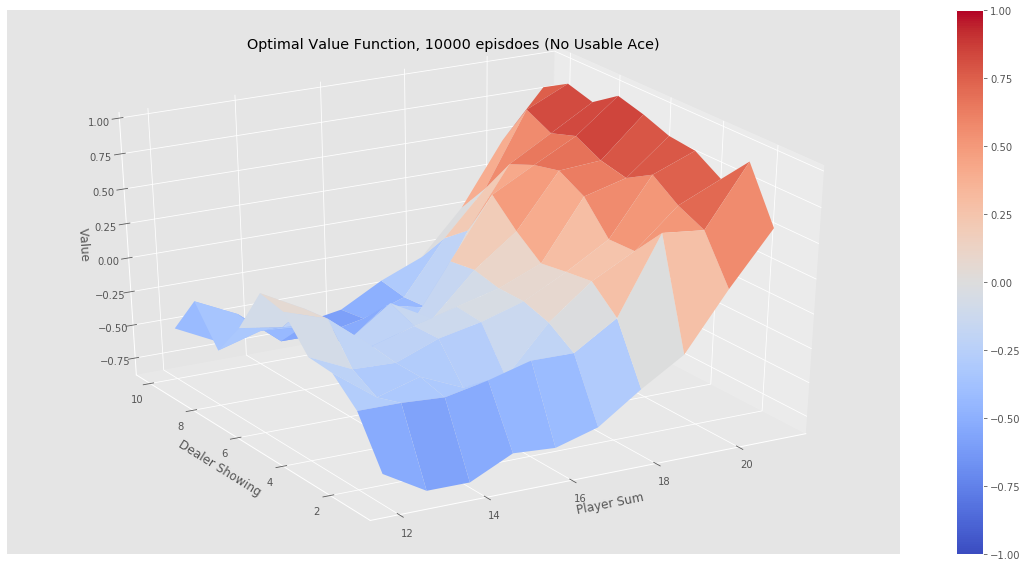

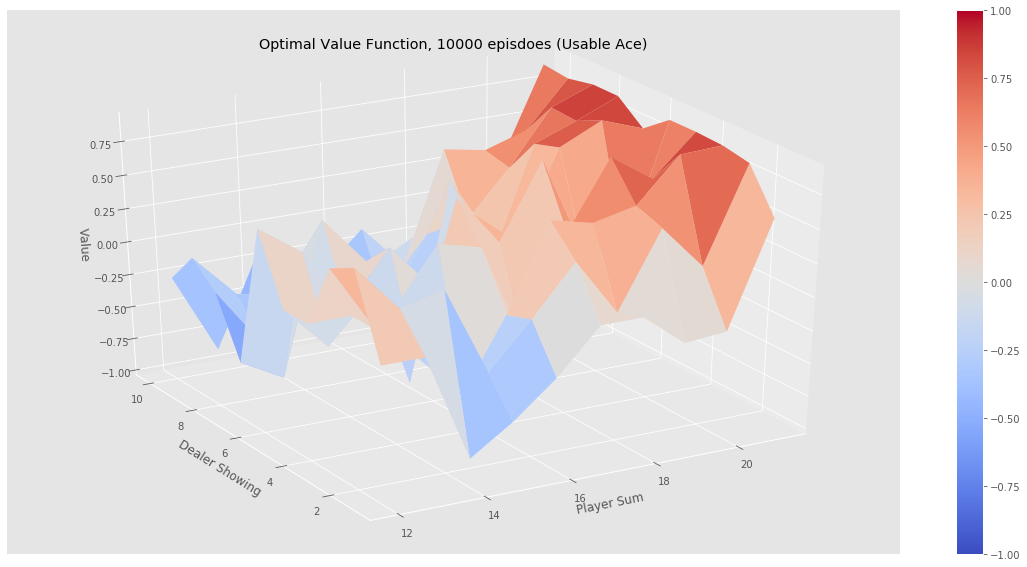

/Users/joachimnilsson/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  if __name__ == '__main__':


10000 episodes
usable ace
mean: 0.2503242542153048
min: -1
max: 1
std: 0.8312066915755095
no usable ace
mean: -0.1440751865129348
min: -1
max: 1
std: 0.871045965097253
Episode 50000/500000.

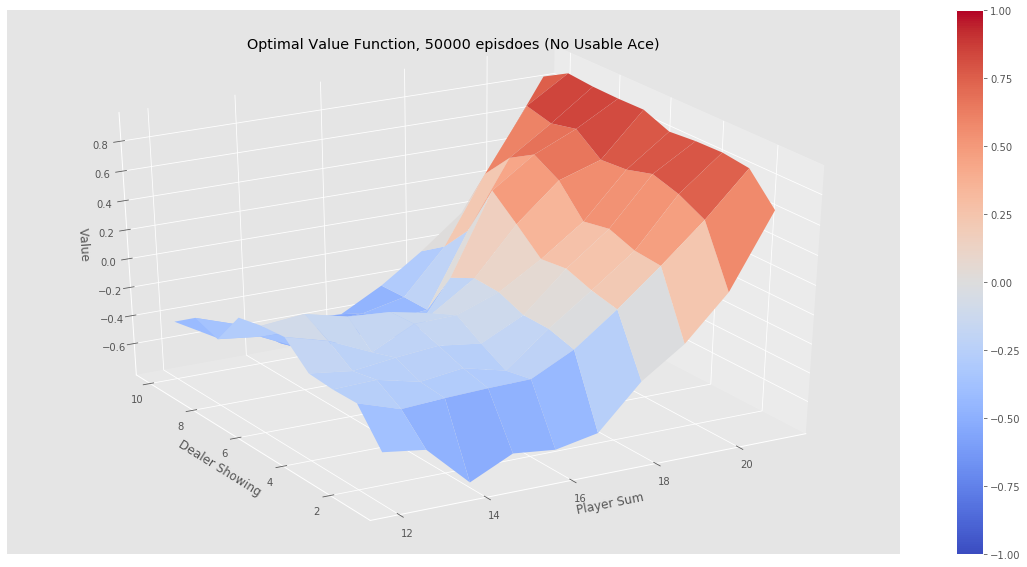

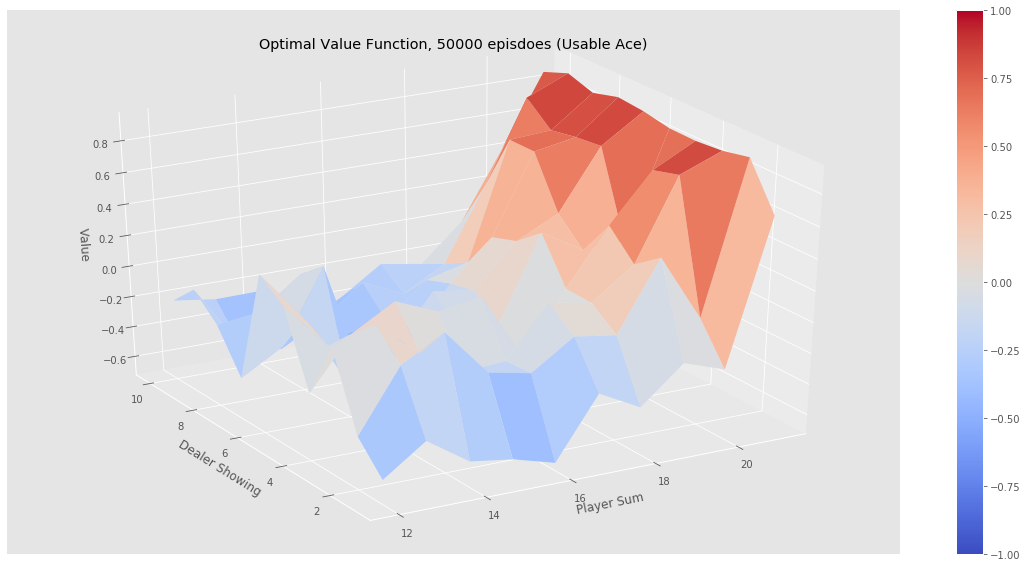

50000 episodes
usable ace
mean: 0.3363259668508287
min: -1
max: 1
std: 0.8036558620294768
no usable ace
mean: -0.12180765214089054
min: -1
max: 1
std: 0.8688147969835873
Episode 100000/500000.

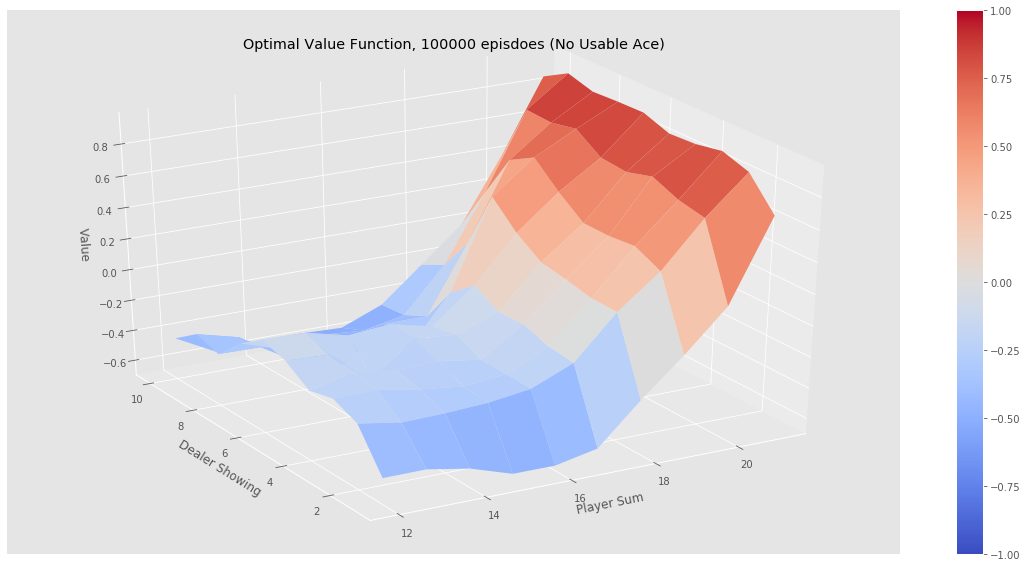

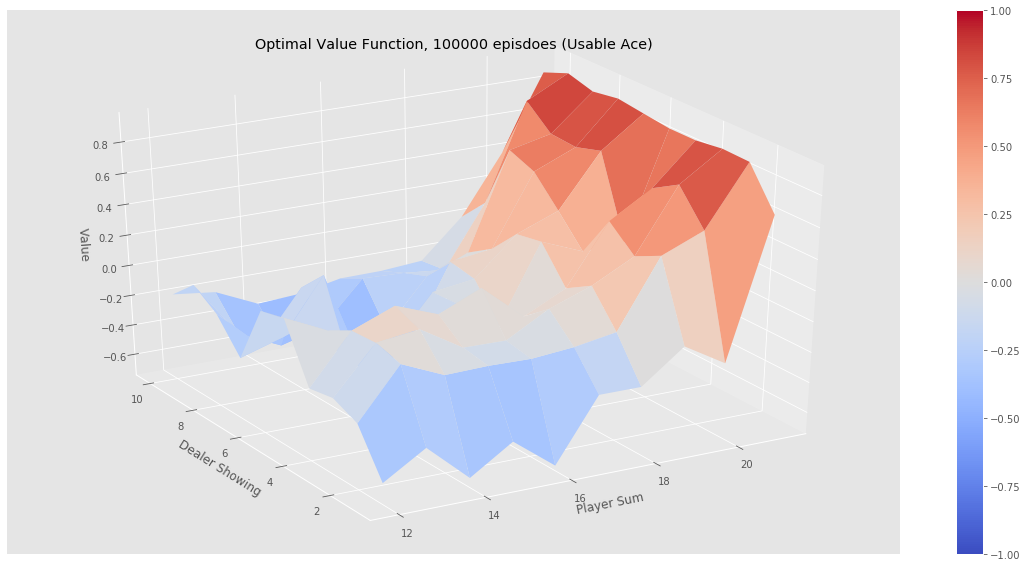

100000 episodes
usable ace
mean: 0.37135450421257293
min: -1
max: 1
std: 0.773094994865652
no usable ace
mean: -0.1091646690023972
min: -1
max: 1
std: 0.8515450608079989
Episode 300000/500000.

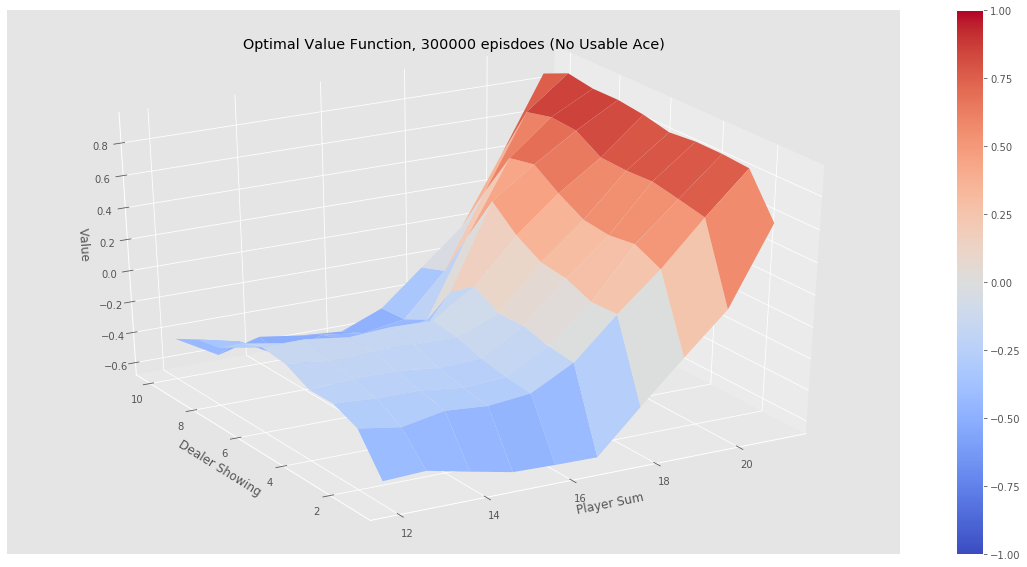

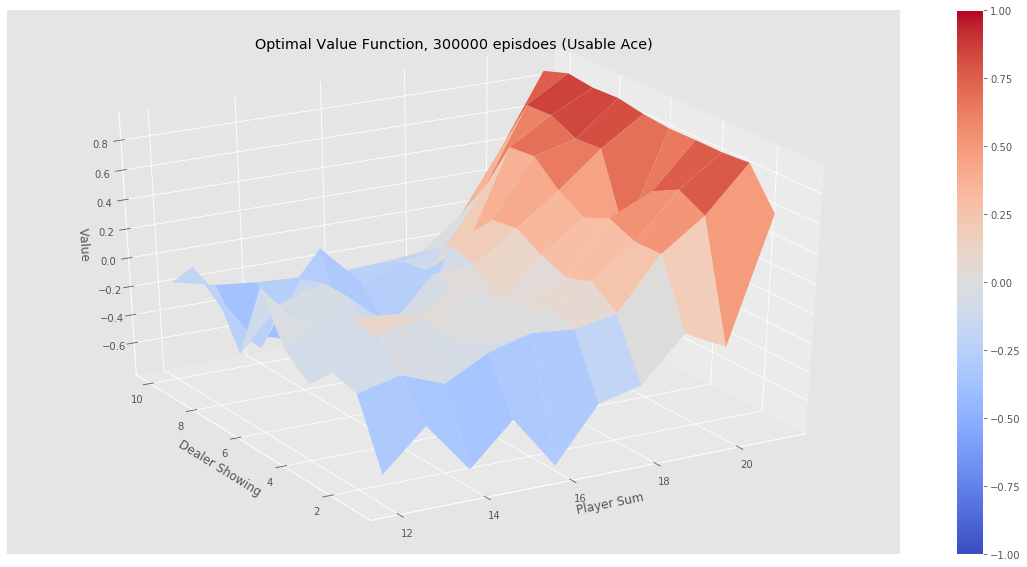

300000 episodes
usable ace
mean: 0.39368556701030927
min: -1
max: 1
std: 0.7701160202443847
no usable ace
mean: -0.11453338251567687
min: -1
max: 1
std: 0.8505942949726043
Episode 400000/500000.

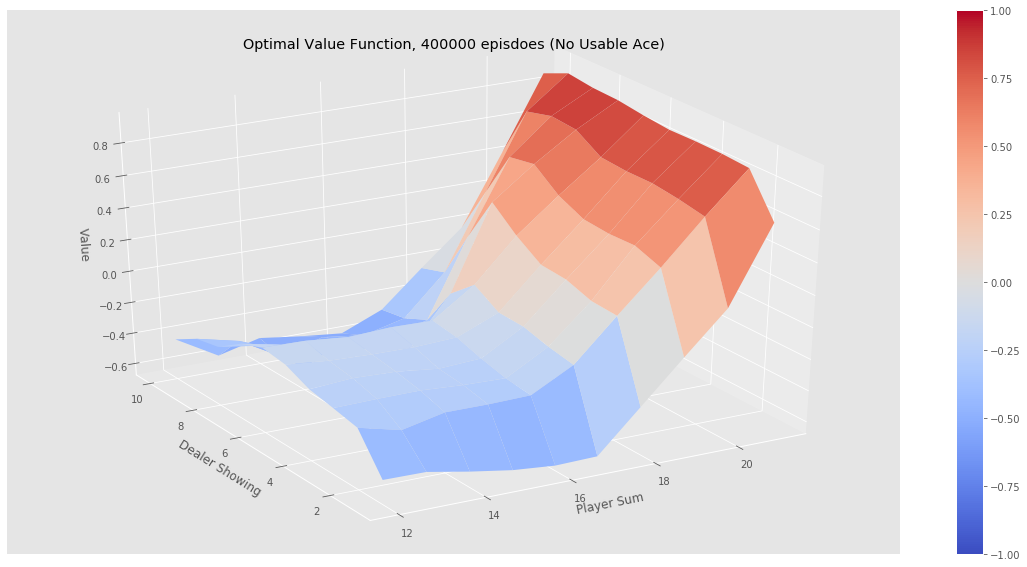

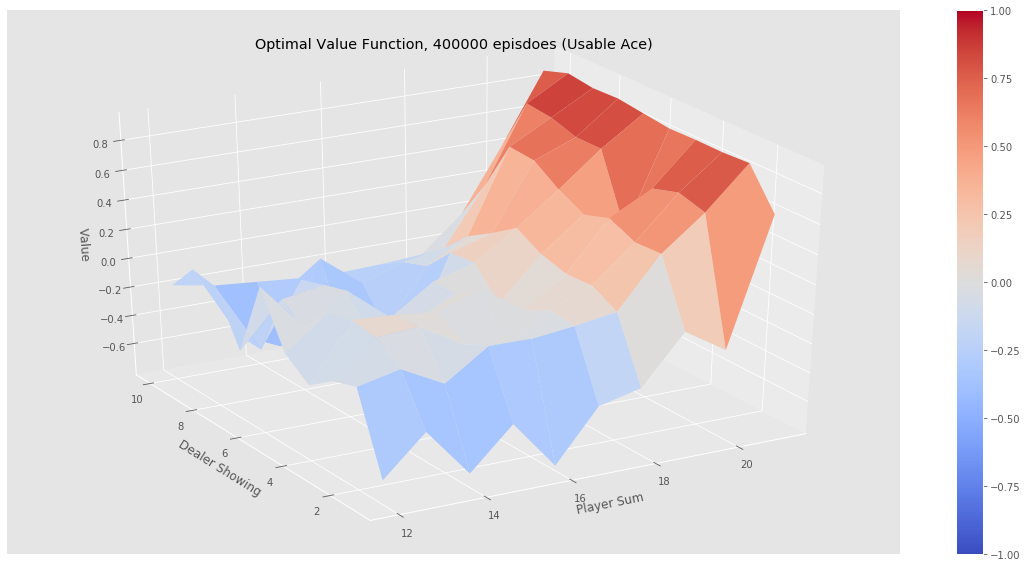

400000 episodes
usable ace
mean: 0.32977303070761016
min: -1
max: 1
std: 0.7781615915114494
no usable ace
mean: -0.11783674221485167
min: -1
max: 1
std: 0.8531522104449704
Episode 500000/500000.

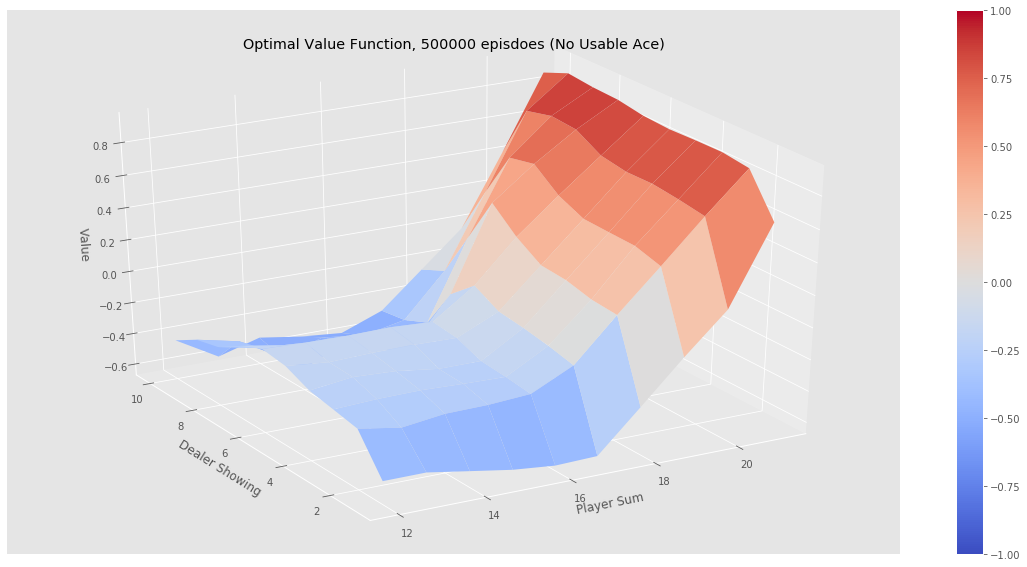

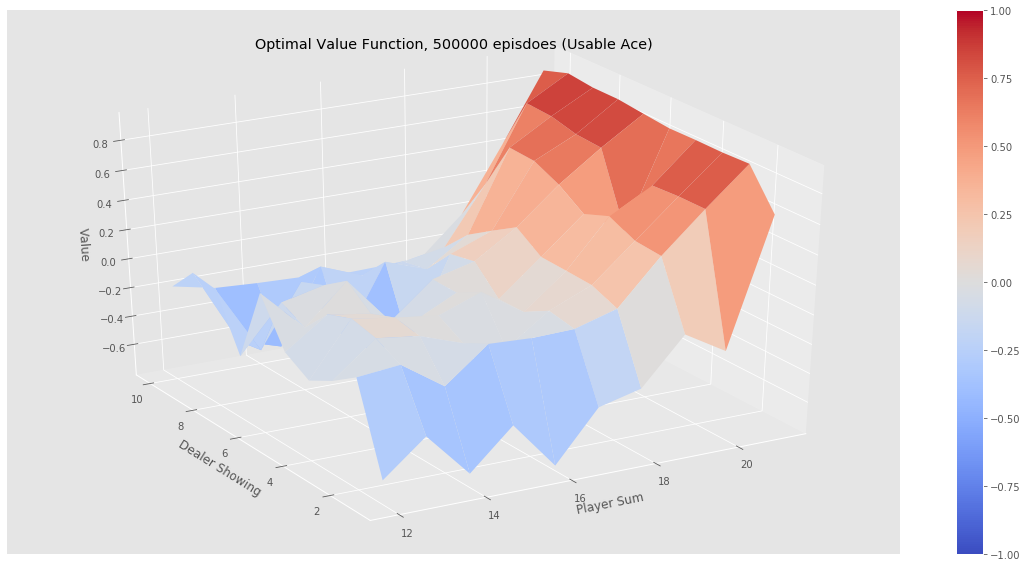

500000 episodes
usable ace
mean: 0.3781793842034806
min: -1
max: 1
std: 0.7557581935193572
no usable ace
mean: -0.10887649693756285
min: -1
max: 1
std: 0.8514990085083801

 108.78635299999996 s


/Users/joachimnilsson/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """


In [81]:
start = time.clock()

Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon_func = lambda x: 1000/(999+x))

end = time.clock()
print("\n",end - start,"s")